In [1]:
import time
import json
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy

# Train own embedding using doc2vec from gensim

## preprocessing

In [94]:
# stopwords
with open('../data/euroleaks/stopwords.json', 'r') as f:
    stopwords = json.load(f)
    
# collocations
def apply_trigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2,b3 in set_colloc:
        res = res.replace(f'{b1} {b2} {b3}', f'{b1}_{b2}_{b3}')
    return res

def apply_bigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2 in set_colloc:
        res = res.replace(f'{b1} {b2}', f'{b1}_{b2}')
    return res

with open('../data/collocations/trigrams.json', 'r') as f:
    trigram_colloc = json.load(f)

with open('../data/collocations/bigrams.json', 'r') as f:
    bigram_colloc = json.load(f)
    
nlp = spacy.load("en_core_web_sm", exclude=["ner"])

def filter_token(token):
    return token.pos_ in {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'}\
        and not token.lemma_.lower() in nlp.Defaults.stop_words\
        and not token.lower_ in stopwords['names']\
        and not token.lower_ in stopwords['disfluency']\
        and not token.lemma_.lower() in stopwords['courtesy']\
        and len(token.lemma_) > 1

In [132]:
leaks = pd.read_csv('../data/euroleaks/squeezed.csv')

# group by speaker
grouped = leaks.drop(columns=['date']).groupby('speaker').apply(lambda s: ' '.join(s.speech))
# get speaker labels
speakers = grouped.index

# make a list of all unidentified speakers
unidentified_speakers = [s for s in speakers if 'speaker' in s]
unidentified_speakers += [
    'irina',
    'kian',
    'male',
    'martin',
    'nabil',
    #'tooma', # I just know that he represents Finland
    'tropa'
]

# get identified speaker labels
identified_speakers = speakers[speakers.to_series().apply(lambda s: s not in unidentified_speakers)]
# filter out unidentified speakers
grouped = grouped[speakers.to_series().apply(lambda s: s not in unidentified_speakers)]


# preprocess
documents = [
    [token.lemma_.lower() for token in nlp(doc) if filter_token(token)]
    for doc in grouped.values 
]


# leave out empty documents
documents = [d for d in documents if len(d) > 0]

speakers = identified_speakers
assert len(documents) == len(speakers)

# apply collocations
documents = [
    apply_bigram_colloc(apply_trigram_colloc(' '.join(doc), trigram_colloc), bigram_colloc).split()
    for doc in documents]

- https://radimrehurek.com/gensim/models/doc2vec.html
- https://radimrehurek.com/gensim/models/doc2vec.html#gensim.models.doc2vec.TaggedDocument

In [99]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

tagged_documents = []

for speaker, doc in zip(speakers, documents):
    
    tagged_documents.append(TaggedDocument(doc, tags=[speaker]))

In [101]:
print(f'There are {len(documents)} documents (speakers).')

There are 31 documents (speakers).


### get sentence length statistics

In [102]:
t = time.time()

doc = nlp(' '.join(leaks.speech.values))

sentences = [[token.lemma_.lower() for token in sentence
                if filter_token(token)
              ] for sentence in doc.sents
            ]

# apply collocations
sentences = [apply_bigram_colloc(apply_trigram_colloc(' '.join(s), trigram_colloc), bigram_colloc).split() for s in sentences]

print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 0.38 mins


In [103]:
# number of words in a sentence statistics
len_sentences = [len(sent) for sent in sentences]
pd.Series(len_sentences).describe()

count    4737.000000
mean        5.733798
std         5.547882
min         0.000000
25%         2.000000
50%         4.000000
75%         8.000000
max        54.000000
dtype: float64

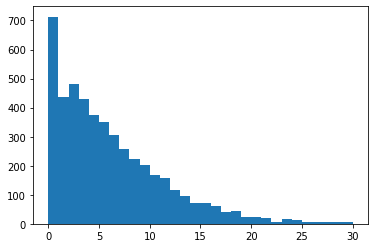

In [104]:
_ = plt.hist(len_sentences, bins=range(31), range=(0,30))

### get speech length statistics

In [105]:
t = time.time()

docs = [
    ' '.join([token.lemma_.lower() for sentence in nlp(doc).sents for token in sentence
              if filter_token(token)
             ])
             for doc in leaks.speech.values
]

# apply collocations
speeches = [apply_bigram_colloc(apply_trigram_colloc(' '.join(sentences), trigram_colloc), bigram_colloc).split() for sentences in docs]

print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 0.14 mins


In [106]:
# number of words in a speech statistics
len_speeches = [len(speech) for speech in speeches]
pd.Series(len_speeches).describe()

count     736.000000
mean      254.989130
std       639.758753
min         0.000000
25%         0.000000
50%        31.000000
75%       227.750000
max      6681.000000
dtype: float64

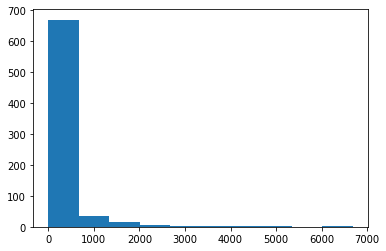

In [107]:
_ = plt.hist(len_speeches)

## Doc2Vec

In [256]:
d2v_model.wv.most_similar('day')

[('create', 0.1961217224597931),
 ('backtracking', 0.17357137799263),
 ('finally', 0.16421820223331451),
 ('regard', 0.1556640863418579),
 ('confidence', 0.14508208632469177),
 ('minister', 0.13195322453975677),
 ('place', 0.12884579598903656),
 ('reform', 0.1280348300933838),
 ('find', 0.11913198232650757),
 ('possibly', 0.11674483120441437)]

In [108]:
d2v_model = Doc2Vec(vector_size=300,
                    window=3,
                    sample=1e-5,
                    negative=20, # usually 5-20
                    min_count=10,
                    #alpha=0.03,
                    #min_alpha=0.000007,
                    workers=-1,
                    epochs=10000,
                    dm=0,
                    dbow_words=1
)

In [109]:
print(f'There are {np.sum([len(d.words) for d in tagged_documents])} total words.')

There are 25501 total words.


**Is this enough for the word embedding to capture word relations?**

In [110]:
d2v_model.build_vocab(tagged_documents)

In [111]:
t = time.time()

d2v_model.train(tagged_documents, 
                total_examples=d2v_model.corpus_count, 
                epochs=100)#d2v_model.epochs)

print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 0.0 mins


In [114]:
keywords = [
    'greece',
    'institution',
    'imf',
    'ecb',
    'commission',
    'government',
    'referendum',
    'mou',
    'debt',
    #'debt_sustainability',
    'pension',
    'bank',
    'bond',
    'crisis'
]

df_closest = pd.DataFrame({word.split('_')[0]: [n.split('_')[0] for n,score in d2v_model.wv.most_similar(word)] for word in keywords})
df_closest

,greece,institution,imf,ecb,commission,government,referendum,mou,debt,pension,bank,bond,crisis
0,separate,pension,direction,step,quickly,push,friday,decision,sense,institution,law,meeting,great
1,basis,order,amendment,imagine,hear,expectation,immediately,successful,exactly,hour,mention,review,bad
2,installment,certain,people,appear,message,primary,clarity,separate,corporate,program,deliver,difficult,negative
3,nominal,sufficiently,contribution,consider,budget,economy,requirement,extent,effect,financial,course,remind,explain
4,mandate,commit,athens,collection,conclusion,account,letter,leave,essential,list,meet,brief,finance
5,extension,money,assistance,greek,happy,short,program,come,ministry,manage,build,analysis,able
6,political,cause,country,vat,payment,regard,greek,conclusion,include,establish,add,hard,reduction
7,obviously,alternative,economy,detail,support,work,couple,condition,economic,possibly,away,letter,promise
8,late,europe,europe,sort,proposal,hour,right,collective,speak,long,successful,positive,decide
9,meet,carry,worried,brussels,mention,sit,extension,sustainable,track,target,essential,lack,development


In [115]:
d2v_model.dv.most_similar('yanis varoufakis', topn=10)

[('edward scicluna', 0.13131935894489288),
 ('peter kažimír', 0.10611923038959503),
 ('pier carlo padoan', 0.09715013206005096),
 ('marco buti', 0.09453482925891876),
 ('pierre moscovici', 0.08684056252241135),
 ('jeroen dijsselbloem', 0.05740758404135704),
 ('harris georgiades', 0.05031723901629448),
 ('thomas steffen', 0.04452574998140335),
 ('maria luís albuquerque', 0.03117670677602291),
 ('tooma', 0.02629617601633072)]

In [116]:
d2v_model.dv.most_similar('christine lagarde', topn=10)

[('luca antonio ricci', 0.1284523755311966),
 ('dušan mramor', 0.11445809155702591),
 ('edward scicluna', 0.09188489615917206),
 ('michael noonan', 0.08791418373584747),
 ('rimantas šadžius', 0.07247788459062576),
 ('hans jörg schelling', 0.06769496947526932),
 ('mario draghi', 0.06357520073652267),
 ('pier carlo padoan', 0.04172747954726219),
 ('wolfgang schäuble', 0.04027819633483887),
 ('maria luís albuquerque', 0.03189289569854736)]

In [117]:
d2v_model.dv['yanis varoufakis'].shape

(300,)

### get speaker embeddings

In [118]:
dvecs = {}
for speaker in speakers:
        dvecs[speaker] = d2v_model.dv[speaker]

In [119]:
X = pd.DataFrame(dvecs).to_numpy().T

### PCA

In [120]:
# center and rescale
X = (X - X.mean(axis=0)) / X.std(axis=0)

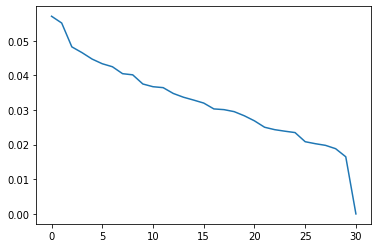

In [121]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# center and rescale
X = StandardScaler().fit_transform(X)

pca = PCA()
X_reduced = pca.fit_transform(X)

plt.plot(pca.explained_variance_ratio_)

In [122]:
np.sum(pca.explained_variance_ratio_)

1.0

### dendrogram

In [126]:
X_reduced.shape

(31, 31)

In [127]:
from scipy.cluster import hierarchy

Z = hierarchy.linkage(X_reduced, method='ward')
#Z = hierarchy.linkage(X, method='ward')

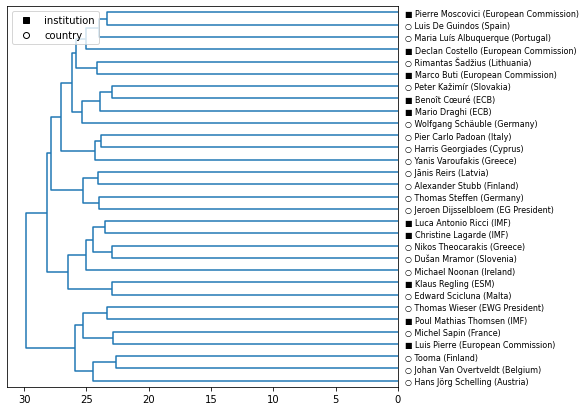

In [129]:
# get labels
with open('../data/euroleaks/name_to_entity.json', 'r') as f:
    speaker_to_entity = json.load(f)

institutions = ['ECB', 'IMF', 'European Commission', 'ESM', 'EFC']
markers = ['\u25a0', '\u25cb']
labels = pd.Series(dvecs.keys()).apply(lambda s: 
        f'{markers[0] if speaker_to_entity[s] in institutions else markers[1]} {s.title()} ({speaker_to_entity[s] if s in speaker_to_entity.keys() else "Unkown"})').to_numpy()

# plot
fig, ax = plt.subplots(figsize=(7,7))

# dendrogram
dn = hierarchy.dendrogram(Z, 
                          orientation='left', 
                          labels=labels,
                          ax=ax
                         )

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='s', label='institution', color='k', linestyle='None'),
    Line2D([0], [0], marker='o', label='country', color='k', markerfacecolor='w', linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper left')

# table - closest words
#topn = 5
#closest_words = pd.DataFrame(
#        data = np.array([[t[0] for t in d2v_model.wv.most_similar(positive=[d2v_model.dv[speaker]], topn=topn)] for speaker in dvecs.keys()]),
#        index = labels
#)

#closest_words = closest_words.T[dn['ivl']].T

#axes[1].table(cellText=closest_words.to_numpy(),
#             loc='upper center')
#axes[1].axis('off')

#axes[1].matshow(np.zeros(closest_words.shape), cmap='Greys')

# xticks
#_ = axes[1].set_xticks([])
#_ = axes[1].set_xticklabels([])
# yticks
#_ = axes[1].set_yticks([])
#_ = axes[1].set_yticklabels([])

# grids
#axes[1].set_xticks(np.arange(-.53, closest_words.shape[1]*3, 3), minor=True)
#axes[1].set_yticks(np.arange(-.53, closest_words.shape[0], 1), minor=True)
#axes[1].grid(which='minor', color='black', linestyle='-', linewidth=.5, alpha=.4)

# values
#for (i,j),z in np.ndenumerate(closest_words.to_numpy()[::-1]):
#    axes[1].text(j*3+1, i, z, ha='center', va='center')#, fontsize='small')

#fig.tight_layout()
#fig.subplots_adjust(wspace=0.05)

**TODO**: but closest words should be closest in original (ndim=300) or PCA-reduced space?

In [130]:
closest_words = pd.DataFrame(
        data = np.array([[t[0] for t in d2v_model.wv.most_similar(positive=[d2v_model.dv[speaker]], topn=5)] for speaker in dvecs.keys()]),
        index = labels
)

#closest_words.T[dn['ivl']].T
closest_words

,0,1,2,3,4
○ Alexander Stubb (Finland),discuss,circumstance,respond,return,april
■ Benoît Cœuré (ECB),advice,law,term,sit,backtrack
■ Christine Lagarde (IMF),rate,talk,sector,huge,commitment
■ Declan Costello (European Commission),institution,concerned,appreciate,push,fact
○ Dušan Mramor (Slovenia),service,labor_market,ensure,interest,produce
○ Edward Scicluna (Malta),sorry,allow,conclude,indicate,wait
○ Hans Jörg Schelling (Austria),finish,speed,beginning,result,matter
○ Harris Georgiades (Cyprus),inform,member_state,helpful,conditionality,partner
○ Jeroen Dijsselbloem (EG President),framework,fully,common,financing,confidence
○ Johan Van Overtveldt (Belgium),press,end,alternative,essential,cut


In [38]:
from collections import Counter

top_n = 10
pd.DataFrame({doc.tags[0]: [w[0] for w in Counter(doc.words).most_common(top_n)] for doc in documents if doc.tags[0] in dvecs.keys()}).T

,0,1,2,3,4,5,6,7,8,9
alexander stubb,try,great,feel,master,windfall,sound,finnish,affect,role,link
benoît cœuré,governance,cover,number,breadth,element,pace,outflow,object,fund,euro
christine lagarde,strategic,smart,constant,indicate,memorandum,include,collection,sit,contribution,bridge
declan costello,bill,touch,intensity,interaction,witness,exclusively,depth,finding,date,element
edward scicluna,dramatic,eurogroup,story,propose,tell,favor,self,destructive,path,solution
jeroen dijsselbloem,floor,listen,paper,conclusion,react,leader,minute,respond,old,line
klaus regling,rating,corporate,triple,agency,speaker,appropriate,geared,protect,indebted,household
luis de guindos,nominal,consideration,inflation,evolution,know,simultaneously,life,maintain,create,confront
luis pierre,publish,sunday,compare,phase,properly,college,recommend,reserve,amendment,share
marco buti,recall,code,indicate,pace,consider,tackle,afford,safety,depth,attend


In [60]:
for doc in documents:
    if doc.tags[0] in dvecs.keys():
        print(doc.tags[0],': ', len(doc.words))

alexander stubb :  743
benoît cœuré :  910
christine lagarde :  1104
declan costello :  301
edward scicluna :  261
jeroen dijsselbloem :  5374
klaus regling :  188
luis de guindos :  1028
luis pierre :  251
marco buti :  716
mario draghi :  797
michael noonan :  687
michel sapin :  184
nikos theocarakis :  841
pier carlo padoan :  391
pierre moscovici :  930
poul mathias thomsen :  920
rimantas šadžius :  560
thomas steffen :  210
thomas wieser :  1507
wolfgang schäuble :  485
yanis varoufakis :  8956


# Pretrained embeddings

- https://kavita-ganesan.com/easily-access-pre-trained-word-embeddings-with-gensim/

In [2]:
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

In [3]:
import time
t = time.time()

#model_name = "word2vec-google-news-300"
model_name = "glove-wiki-gigaword-300"
#model_name = "fasttext-wiki-news-subwords-300"
#model_name = "glove-twitter-200"

# download the model and return as object ready for use
model = api.load(model_name)

print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 1.06 mins


In [4]:
#model['interest_rate'] # to get vector
#model.__contains__('interest rate') # returns bool
#model.most_similar("eurogroup",topn=10) # closest neighbors
type(model)

gensim.models.keyedvectors.KeyedVectors

## preprocessing

In [5]:
# stopwords
with open('../data/euroleaks/stopwords.json', 'r') as f:
    stopwords = json.load(f)
    
# collocations
def apply_trigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2,b3 in set_colloc:
        res = res.replace(f'{b1} {b2} {b3}', f'{b1}_{b2}_{b3}')
    return res

def apply_bigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2 in set_colloc:
        res = res.replace(f'{b1} {b2}', f'{b1}_{b2}')
    return res

with open('../data/collocations/trigrams.json', 'r') as f:
    trigram_colloc = json.load(f)

with open('../data/collocations/bigrams.json', 'r') as f:
    bigram_colloc = json.load(f)
    
nlp = spacy.load("en_core_web_sm", exclude=["ner"])

def filter_token(token):
    return token.pos_ in {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'}\
        and not token.lemma_.lower() in nlp.Defaults.stop_words\
        and not token.lower_ in stopwords['names']\
        and not token.lower_ in stopwords['disfluency']\
        and not token.lemma_.lower() in stopwords['courtesy']\
        and len(token.lemma_) > 1

In [6]:
leaks = pd.read_csv('../data/euroleaks/squeezed.csv')

# group by speaker
grouped = leaks.drop(columns=['date']).groupby('speaker').apply(lambda s: ' '.join(s.speech))
# get speaker labels
speakers = grouped.index

# make a list of all unidentified speakers
unidentified_speakers = [s for s in speakers if 'speaker' in s]
unidentified_speakers += [
    'irina',
    'kian',
    'male',
    'martin',
    'nabil',
    #'tooma', # I just know that he represents Finland
    'tropa'
]

# get identified speaker labels
identified_speakers = speakers[speakers.to_series().apply(lambda s: s not in unidentified_speakers)]
# filter out unidentified speakers
grouped = grouped[speakers.to_series().apply(lambda s: s not in unidentified_speakers)]


# preprocess
documents = [
    [token.lemma_.lower() for token in nlp(doc) if filter_token(token)]
    for doc in grouped.values 
]


# leave out empty documents
documents = [d for d in documents if len(d) > 0]

# IMPORTANT
speakers = identified_speakers


assert len(documents) == len(speakers)

# DO NOT apply collocations, because they are not in the embedding
# documents = [
#     apply_bigram_colloc(apply_trigram_colloc(' '.join(doc), trigram_colloc), bigram_colloc).split()
#     for doc in documents]

### missing words
Account for words that are in the corpus but not in the embedding.

In [7]:
print(f'Percent of words not in embedding: {np.round(np.mean([not model.__contains__(word) for doc in documents for word in doc])*100,2)} %')

Percent of words not in embedding: 1.06 %


In [8]:
missing_words = [word for doc in documents for word in doc if not model.__contains__(word)]
print(len(missing_words))
missing_words[:10]

278


['are-',
 'and-',
 'in-',
 'governmentalism',
 'wolgang',
 'eurosummit',
 'eurosummit',
 'wolgfang',
 'aide-',
 'p-']

## construct document vectors

In [9]:
# aggregate by mean

dvecs = {
    speaker: np.mean([model[word] for word in doc if model.__contains__(word)], axis=0)
    for speaker,doc in zip(speakers,documents)
}

X = pd.DataFrame(dvecs).to_numpy().T
X.shape

(31, 300)

In [10]:
# can also aggregate by min, max, concatenate

## PCA

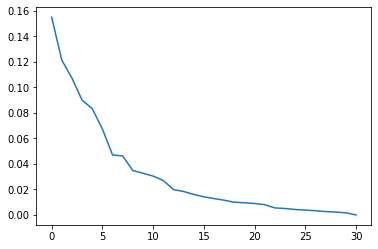

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# center and rescale
X = StandardScaler().fit_transform(X)

pca = PCA()
X_reduced = pca.fit_transform(X)

plt.plot(pca.explained_variance_ratio_)

In [12]:
np.sum(pca.explained_variance_ratio_[:25])

0.986406

## dendrogram

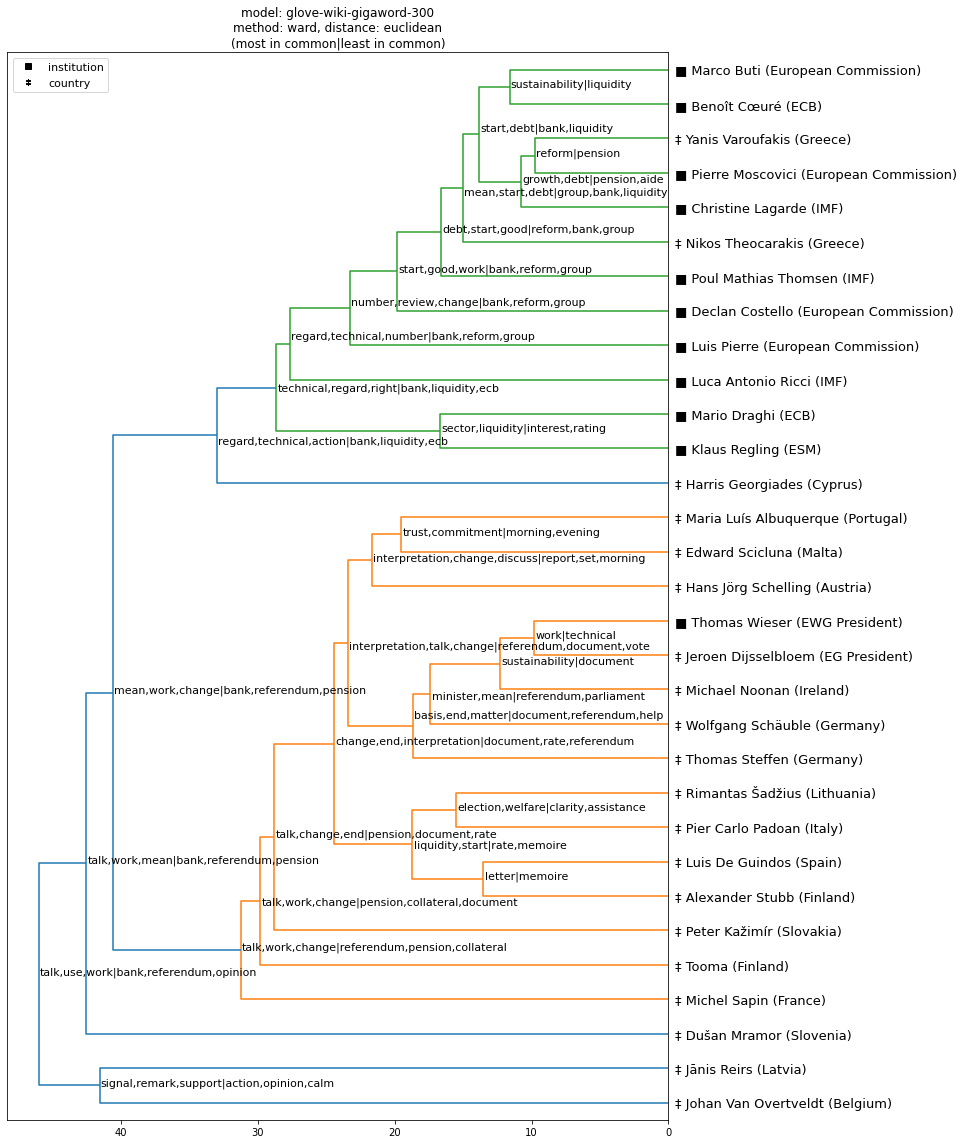

In [143]:
# agglomerative clustering
from scipy.cluster import hierarchy

linkage_method, metric = 'ward', 'euclidean'
#linkage_method, metric = 'average', 'cosine'

#Z = hierarchy.linkage(X, method='single', metric='cosine' or euclidean)
Z = hierarchy.linkage(X_reduced, method=linkage_method, metric=metric)

# get labels
with open('../data/euroleaks/name_to_entity.json', 'r') as f:
    speaker_to_entity = json.load(f)

institutions = ['ECB', 'IMF', 'European Commission', 'ESM', 'EFC', 'EWG President']
#markers = ['\u2020', '\u2021'] # previously: ['\u25a0', '\u25cb']
markers = ['\u25a0', '\u2021']

labels = pd.Series(dvecs.keys()).apply(lambda s: 
        f'{markers[0] if speaker_to_entity[s] in institutions else markers[1]} {s.title()} ({speaker_to_entity[s] if s in speaker_to_entity.keys() else "Unkown"})').to_numpy()

# plot
fig, ax = plt.subplots(figsize=(13.5,16))

# dendrogram
dn = hierarchy.dendrogram(Z, 
                          orientation='left', 
                          labels=labels,
                          ax=ax,
                         )

# control label font size
ax.tick_params(axis='y', which='major', labelsize=10)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='s', label='institution', color='k', linestyle='None'),
    Line2D([0], [0], marker='$\u2021$', label='country', color='k', markerfacecolor='w', linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=11)

ax.tick_params(axis='y', which='major', labelsize=13)

# significant words (max|min)
# max: word that the cluster has most in common
# min: word that the cluster has least in common
for i,(words,loc) in enumerate(zip(significant_words, text_locations)):
    ax.text(Z[i,2]-0.1, loc*10+5, words, fontsize=11)

ax.set_title(f'model: {model_name}\nmethod: {linkage_method}, distance: {metric}\n(most in common|least in common)')#\n(max|min)')
fig.tight_layout()

fig.savefig(f'../figures/dendrogram-{model_name}-{linkage_method}-{metric}.png', facecolor='white')

In [65]:
text_locations_old = np.copy(text_locations)

In [142]:
# manual intreventions for text annotation

# fasttext wiki average cosine
# significant_words[0] = 'liquidity,reform|rate,bond'

# text_locations = np.copy(text_locations_old) # reset locations
# text_locations[4] -= .2
# text_locations[23] -= .2
# text_locations[10] -= .2
# text_locations[19] -= .2
# text_locations[27] += .05
# text_locations[21] -= .2

# fasttext wiki ward euclidean
# significant_words[0] = 'work|aide'
# significant_words[6] = 'look,reach|rate,aide'
# significant_words[7] = 'euro,place|rate,document'
# significant_words[1] = 'work|letter'
# significant_words[4] = 'turn,team|document,gap'
# significant_words[3] = 'reform|group'
# significant_words[5] = 'reform,euro|group,mean'
# significant_words[8] = 'regard,review|mean,group'
# significant_words[2] = 'liquidity|rate'
# significant_words[11] = 'letter,mean|context,mou'

# text_locations = np.copy(text_locations_old) # reset locoations
# text_locations[18] -= .1
# text_locations[-9] -= .2
# text_locations[-14] -= .35
# text_locations[-10] += .2
# text_locations[1] -= .1
# text_locations[-4] += .2
# text_locations[-7] -= .2
# text_locations[11] -= .1
# text_locations[3] -= .2
# text_locations[5] -= .1
# text_locations[8] -= .2
# text_locations[-3] -= .1

# glove wiki average cosine
# significant_words[3] = 'letter,set|document,position'
# significant_words[0] = 'liquidity|rate'

# text_locations = np.copy(text_locations_old) # reset locoations
# text_locations[-3] -= .2
# text_locations[-8] -= .2
# text_locations[-4] += .08
# text_locations[8] -= .1
# text_locations[-1] -= .25
# text_locations[10] -= .2

# glove wiki ward euclidean
significant_words[0] = 'reform|pension'
significant_words[1] = 'work|technical'
significant_words[3] = 'sustainability|liquidity'
significant_words[6] = 'start,debt|bank,liquidity'
significant_words[2] = 'growth,debt|pension,aide'
significant_words[10] = 'sector,liquidity|interest,rating'
significant_words[14] = 'trust,commitment|morning,evening'
significant_words[4] = 'sustainability|document'
significant_words[11] = 'minister,mean|referendum,parliament'
significant_words[8] = 'election,welfare|clarity,assistance'
significant_words[13] = 'liquidity,start|rate,memoire'
significant_words[5] = 'letter|memoire'

text_locations = np.copy(text_locations_old) # reset locoations
text_locations[6] += .1
text_locations[7] -= .2
text_locations[-13] += .1
text_locations[-10] += .15
text_locations[-9] -= .1
text_locations[-5] -= .25
text_locations[-12] -= .15
text_locations[12] += .25
text_locations[11] -= .15
text_locations[13] -= .1
text_locations[-7] -= .1

In [131]:
significant_words

['reform|pension',
 'work|technical',
 'growth,debt|pension,aide',
 'sustainability|liquidity',
 'sustainability|document',
 'letter|memoire',
 'start,debt|bank,liquidity',
 'mean,start,debt|group,bank,liquidity',
 'election,welfare|clarity,assistance',
 'debt,start,good|reform,bank,group',
 'sector,liquidity|interest,rating',
 'minister,mean|referendum,parliament',
 'basis,end,matter|document,referendum,help',
 'liquidity,start|rate,memoire',
 'trust,commitment|morning,evening',
 'start,good,work|bank,reform,group',
 'interpretation,change,discuss|report,set,morning',
 'number,review,change|bank,reform,group',
 'interpretation,talk,change|referendum,document,vote',
 'change,end,interpretation|document,rate,referendum',
 'regard,technical,number|bank,reform,group',
 'technical,regard,right|bank,liquidity,ecb',
 'talk,change,end|pension,document,rate',
 'talk,work,change|pension,collateral,document',
 'talk,work,change|referendum,pension,collateral',
 'regard,technical,action|bank,liqui

### get most significant word for each cluster

In [57]:
import re

leaks = pd.read_csv('../data/euroleaks/squeezed.csv')

# group by speaker
grouped = leaks.drop(columns=['date']).groupby('speaker').apply(lambda s: ' '.join(s.speech))
# get speaker labels
speakers = grouped.index

# make a list of all unidentified speakers
unidentified_speakers = [s for s in speakers if 'speaker' in s]
unidentified_speakers += [
    'irina',
    'kian',
    'male',
    'martin',
    'nabil',
    #'tooma', # I just know that he represents Finland
    'tropa'
]

# get identified speaker labels
identified_speakers = speakers[speakers.to_series().apply(lambda s: s not in unidentified_speakers)]
# filter out unidentified speakers
grouped = grouped[speakers.to_series().apply(lambda s: s not in unidentified_speakers)]

# preprocess (also remmove numbers) 
contains_digit = re.compile('\d')
documents_ = [[f'{token.lemma_.lower()}_{token.pos_}' for token in nlp(doc) if filter_token(token) and not contains_digit.match(token.text)] 
              for doc in grouped.values
             ]
              
# leave out empty documents
documents_ = [d for d in documents_ if len(d) > 0]

# important to do this to avoid confusion
speakers = identified_speakers

In [58]:
# construct candidate words by removing too frequent words from vocabuary

from gensim.corpora import Dictionary

dictionary = Dictionary(documents_)

no_below=1
no_above=.5

# see what will be removed
no_below_removed = [dictionary.get(token_id) for token_id, freq in dictionary.cfs.items() if freq < no_below]
no_above_removed = [dictionary.get(token_id) for token_id, freq in dictionary.dfs.items() if freq > no_above * len(documents)]

print(f'no_below will remove {len(no_below_removed)} tokens.')
print(f'no_above will remove {len(no_above_removed)} tokens.')

dictionary.filter_extremes(
    no_below=no_below,  # Keep tokens which are contained in at least no_below documents.
    no_above=no_above # Keep tokens which are contained in no more than no_above documents (fraction of total corpus size, not an absolute number).
)

no_below will remove 0 tokens.
no_above will remove 56 tokens.


In [59]:
candidate_words = [word.split('_')[0] for word in list(dictionary.values()) if word.split('_')[1] in ['NOUN']]

len(candidate_words)

1512

In [60]:
def flatten(l1):
    
    if len(l1) == 1:
        if type(l1[0]) == list:
            result = flatten(l1[0])
        else:
            result = l1

    #recursive case
    elif type(l1[0]) == list:
        result = flatten(l1[0]) + flatten(l1[1:])
    else:
        result = [l1[0]] + flatten(l1[1:])
        
    return result
    
#flatten([1,[2,[3,4],5],6])

In [61]:
dn_labels = pd.Series(dn['ivl']).apply(lambda s: ' '.join(s.lower().split('(')[0].strip().split(' ')[1:])).to_numpy()

In [62]:
speakers_ = list(dvecs.keys())
locations = [np.where(dn_labels == s)[0][0] for s in speakers_]

text_locations = []
clusters = []

for x,y in Z[:,:2].astype(int):
    
    cluster = flatten([speakers_[x], speakers_[y]])
    clusters.append(cluster)
    speakers_.append(cluster)
    
    loc = np.mean([locations[x], locations[y]])
    text_locations.append(loc)
    locations.append(loc)

#clusters
#locations

In [63]:
import time
from collections import defaultdict

from itertools import combinations as comb
from scipy.spatial.distance import pdist

# metric is set by the dendrogram code block

# helper function
def cluster_avg_dist(vecs, cluster):
    
    distances = []
    
    for pair in comb(cluster, 2):
        X_ = np.vstack([vecs[pair[0]], vecs[pair[1]]])
        # transform to PCA reduced space (same as dendrogram)
        X_ = pca.transform(X_) # remark: not fitting, just transforming
        distances.append(pdist(X_, metric=metric)[0])
        
    return np.mean(distances)
    
    
    
t = time.time()

words_by_speaker = {s: d for s,d in zip(speakers,documents)}

candidate_words_scores = defaultdict(dict)

for cluster_id, cluster in enumerate(clusters):
    
    # get average distance of cluster members without removing the word
    # REMARK: dvecs vs vecs
    vanilla_dist = cluster_avg_dist(dvecs, cluster)
    
    for i, word in enumerate(candidate_words):

        # get vectors of documents, leaving out the current word
        vecs = {}
        for speaker in cluster:
            vecs[speaker] = np.mean([model[w] for w in words_by_speaker[speaker] if model.__contains__(w) and w!=word], axis=0)
            #if word in words_by_speaker[speaker]:
            #    assert not np.array_equal(dvecs[speaker], vecs[speaker])
            #else:
            #    assert np.array_equal(dvecs[speaker], vecs[speaker])

        # compute distances between all speaker in cluster
        candidate_words_scores[cluster_id][word] =  cluster_avg_dist(vecs, cluster)
        
        # check if word belongs only to one speaker in cluster
        flag_single = np.sum([word in words for words in words_by_speaker.values()]) < 2
        
        candidate_words_scores[cluster_id][f'{word}_is_single'] = flag_single
        

print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 22.26 mins


In [141]:
top_n = 3

significant_words = []

for d in candidate_words_scores.values():
    
    mask = pd.Series(candidate_words_scores[0].keys()).apply(lambda s: 'is_single' not in s).values
    
    scores = np.array(list(d.values()))[mask]
    
    words = np.array(list(d.keys()))[mask]
                      
    flags = np.array(list(d.values()))[np.invert(mask)]
    
    ix_lowest = np.argsort(scores)
    ix_highest = ix_lowest[::-1]
                      
    for ix in ix_lowest[:top_n]:
        if flags[ix]:
            words[ix] = f'\u2055{words[ix]}'
                      
    for ix in ix_highest[:top_n]:
        if flags[ix]:
            words[ix] = f'\u2055{words[ix]}'
    
    min_words = ','.join(words[ix_lowest[:top_n]])
    max_words = ','.join(words[ix_highest[:top_n]])
            
    
    significant_words.append(f'{max_words}|{min_words}')

significant_words

['reform,privatization,expenditure|pension,tax,parliament',
 'work,hope,communication|technical,letter,reform',
 'growth,debt,flexibility|memoire,pension,aide',
 'start,sustainability,number|bank,liquidity,mean',
 'sustainability,basis,hope|document,position,aide',
 'letter,perspective,bit|memoire,expectation,euro',
 'mean,start,debt|bank,liquidity,memoire',
 'mean,start,debt|group,bank,liquidity',
 'election,welfare,state|clarity,assistance,referendum',
 'debt,start,good|reform,bank,group',
 'sector,strengthen,liquidity|interest,rating,agency',
 'minister,mean,basis|referendum,document,parliament',
 'basis,end,matter|document,referendum,help',
 'liquidity,start,⁕trajectory|rate,memoire,market',
 'trust,commitment,deal|morning,evening,assessment',
 'start,good,work|bank,reform,group',
 'interpretation,change,discuss|report,set,morning',
 'number,review,change|bank,reform,group',
 'interpretation,talk,change|referendum,document,vote',
 'change,end,interpretation|document,rate,referendum

In [191]:
top_n = 10

for i, cluster in enumerate(clusters):
    print(' '.join(cluster))
    
    ix_lowest = np.argsort(list(candidate_words_scores[i].values()))
    ix_highest = ix_lowest[::-1]
    
    print('\n\tmin:')
    for w in np.array(list(candidate_words_scores[i].keys()))[ix_lowest][:top_n]:
        print(f'\t\t{w}')
    print('\n\tmin:')
    for w in np.array(list(candidate_words_scores[i].keys()))[ix_highest][:top_n]:
        print(f'\t\t{w}')
    
    print()

benoît cœuré mario draghi

	min:
		rate
		bond
		ela
		debt
		credit
		bank
		interest
		low
		solvency
		collateral

	min:
		liquidity
		reform
		number
		development
		system
		area
		public
		outline
		general
		purpose

yanis varoufakis benoît cœuré mario draghi

	min:
		bank
		rate
		bond
		interest
		collateral
		liquidity
		banking
		credit
		solvency
		area

	min:
		reform
		start
		discuss
		remark
		tax
		use
		mean
		step
		conclusion
		public

pierre moscovici poul mathias thomsen

	min:
		reform
		tax
		debt
		talk
		pension
		minister
		gdp
		chief
		relief
		budget

	min:
		year
		place
		key
		good
		gap
		area
		regard
		change
		low
		start

michel sapin wolfgang schäuble

	min:
		context
		mou
		french
		expression
		element
		language
		hour
		speech
		background
		future

	min:
		mean
		letter
		change
		work
		reject
		sorry
		use
		place
		talk
		parliament

klaus regling yanis varoufakis benoît cœuré mario draghi

	min:
		rating
		bank
		issuer
		agency
		ecb
		

In [ ]:
closest_words = pd.DataFrame(
        data = np.array([[t[0] for t in d2v_model.wv.most_similar(positive=[d2v_model.dv[speaker]], topn=5)] for speaker in dvecs.keys()]),
        index = labels
)

#closest_words.T[dn['ivl']].T
closest_words

## Produce all the dendrograms figures in one run

In [16]:
import time

from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
from itertools import combinations as comb
from scipy.spatial.distance import pdist

In [17]:
# get labels
with open('../data/euroleaks/name_to_entity.json', 'r') as f:
    speaker_to_entity = json.load(f)
    
institutions = ['ECB', 'IMF', 'European Commission', 'ESM', 'EFC']
markers = ['\u25a0', '\u25cb']

# get vocabulary
vocabulary = np.unique(np.concatenate([documents[i].words for i in range(len(documents))]))

# get words by speaker
words_by_speaker = {d.tags[0]: d.words for d in documents}

In [18]:
def flatten(l1):  
    
    if len(l1) == 1:
        if type(l1[0]) == list:
            result = flatten(l1[0])
        else:
            result = l1
            
    #recursive case
    elif type(l1[0]) == list:
        result = flatten(l1[0]) + flatten(l1[1:])
    else:
        result = [l1[0]] + flatten(l1[1:])      
        
    return result


def cluster_avg_dist(vecs, cluster):
    
    distances = []
    
    for pair in comb(cluster, 2):
        X_ = np.vstack([vecs[pair[0]], vecs[pair[1]]])
        # transform to PCA reduced space (same as dendrogram)
        X_ = pca.transform(X_)
        distances.append(pdist(X_, metric=metric)[0])
        
    return np.mean(distances)

In [ ]:
model_names = [
    "word2vec-google-news-300",
    "glove-wiki-gigaword-300",
    "fasttext-wiki-news-subwords-300",
    "glove-twitter-200"
]

metric = 'euclidean'

for model_name in model_names[:2]:
    
    t = time.time()
    print(f'### {model_name} ###')
    
    # download/load the model and return as object ready for use
    model = api.load(model_name)
    print(f'\tload model time taken: {round((time.time() - t) / 60, 2)} mins')
    
    # build document vectors
    dvecs = {
        d.tags[0]: np.mean([model[word] for word in d.words if model.__contains__(word)], axis=0)
        for d in documents if d.tags[0] not in insignificant_speakers and 'speaker' not in d.tags[0]
    }
    
    # build matrix
    X = pd.DataFrame(dvecs).to_numpy().T
    
    # PCA
    X = StandardScaler().fit_transform(X)
    pca = PCA()
    X_reduced = pca.fit_transform(X)
    
    # dendrogram (no plot)
    #Z = hierarchy.linkage(X, method='single', metric='cosine')
    Z = hierarchy.linkage(X_reduced, method='ward', metric='euclidean')

    labels = pd.Series(dvecs.keys()).apply(lambda s: 
        f'{markers[0] if speaker_to_entity[s] in institutions else markers[1]} {s.title()} ({speaker_to_entity[s] if s in speaker_to_entity.keys() else "Unkown"})').to_numpy()

    dn = hierarchy.dendrogram(Z, 
                          orientation='left', 
                          labels=labels,
                          no_plot=True)
    
    # get labels from dendrogram (different order than just labels)
    dn_labels = pd.Series(dn['ivl']).apply(lambda s: ' '.join(s.lower().split('(')[0].strip().split(' ')[1:])).to_numpy()
    
    # get clusters and text locations
    speakers = list(dvecs.keys())
    locations = [np.where(dn_labels == s)[0][0] for s in speakers]

    text_locations = []
    clusters = []

    for x,y in Z[:,:2].astype(int):

        cluster = flatten([speakers[x], speakers[y]])
        clusters.append(cluster)
        speakers.append(cluster)

        loc = np.mean([locations[x], locations[y]])
        text_locations.append(loc)
        locations.append(loc)
        
    # get most significant words
    t = time.time()
    significant_words = []

    for cluster in clusters:

        # get average distance of cluster members without removing the word
        # REMARK: dvecs vs vecs
        max_dist = min_dist = cluster_avg_dist(dvecs, cluster)

        max_target_word = min_target_word = ''

        for word in vocabulary[:10]:

            # maybe compute only for words that are shared by all speakers in cluster

            # get vectors of documents, leaving out the current word
            vecs = {}
            for speaker in cluster:
                vecs[speaker] = np.mean([model[w] for w in words_by_speaker[speaker] if model.__contains__(w) and w!=word], axis=0)

            # compute distances between all speaker in cluster
            new_cluster_avg_dist = cluster_avg_dist(vecs, cluster)

            if new_cluster_avg_dist > max_dist:
                max_dist = new_cluster_avg_dist
                max_target_word = word

            if new_cluster_avg_dist < min_dist:
                min_dist = new_cluster_avg_dist
                min_target_word = word

        significant_words.append((max_target_word, min_target_word))

    print(f'\tsignificant words time taken: {round((time.time() - t) / 60, 2)} mins')
    
    # release memory
    del model
    
    # make plot
    fig, ax = plt.subplots(figsize=(10,7))

    dn = hierarchy.dendrogram(Z, 
                              orientation='left', 
                              labels=labels,
                              ax=ax
                             )

    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='s', label='institution', color='k', linestyle='None'),
        Line2D([0], [0], marker='o', label='country', color='k', markerfacecolor='w', linestyle='None')
    ]
    ax.legend(handles=legend_elements, loc='upper left')

    # significant words (max|min)
    # max: word that the cluster has least in common
    # min: word that the cluster has most in common
    for i,(words,loc) in enumerate(zip(significant_words, text_locations)):
        ax.text(Z[i,2]-0.2, loc*10+3.5, f'{words[0]}|{words[1]}')

    ax.set_title(model_name)
    fig.tight_layout()

    fig.savefig(f'../figures/wip/{model_name}.png', facecolor='white')

### word2vec-google-news-300 ###


### sense2vec

In [15]:
from sense2vec import Sense2Vec
s2v = Sense2Vec().from_disk("/home/asajina/downloads/s2v_reddit_2015_md/s2v_old")

In [16]:
"greece|NOUN" in s2v

True

In [18]:
#s2v["greece|NOUN"]

In [27]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

t = time.time()

documents = []
for speaker, text in grouped.iteritems():
    
    doc = nlp(text)
    
    doc_ = [f'{token.lemma_}|{token.pos_.upper()}' for sentence in doc.sents for token in sentence
                if filter_token(token)
            ]
    
    # apply collocations
    #doc_ = apply_bigram_colloc(apply_trigram_colloc(' '.join(doc_), trigram_colloc), bigram_colloc).split()
    
    # maybe add date to tags, or country/intitution?
    # TaggedDocument takes list of words as input
    documents.append(TaggedDocument(doc_, tags=[speaker]))
    
print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 0.82 mins


In [28]:
documents[0].words[0]

'thank|VERB'

In [29]:
dvecs = {
    d.tags[0]: np.mean([s2v[word] for word in d.words if word in s2v], axis=0)
    for d in documents if d.tags[0] not in insignificant_speakers and 'speaker' not in d.tags[0]
}

X = pd.DataFrame(dvecs).to_numpy().T
X.shape

(22, 128)

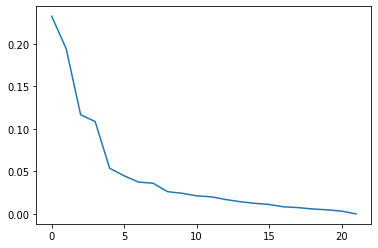

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# center and rescale
X = StandardScaler().fit_transform(X)

pca = PCA()
X_reduced = pca.fit_transform(X)

plt.plot(pca.explained_variance_ratio_)

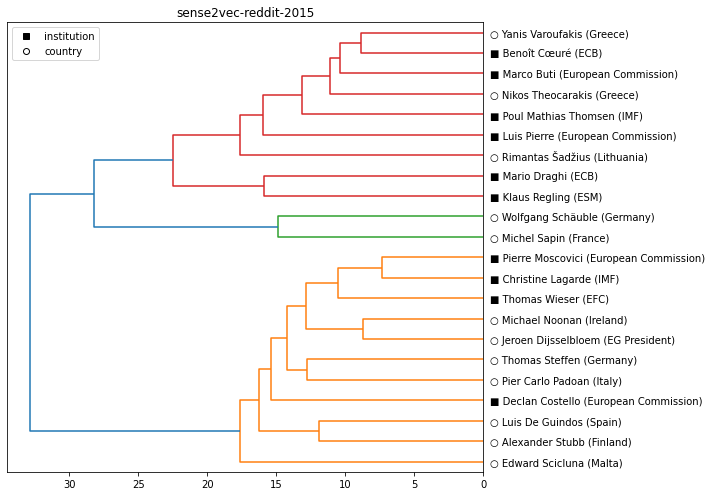

In [32]:
# agglomerative clustering
from scipy.cluster import hierarchy

Z = hierarchy.linkage(X_reduced, method='ward')

# get labels
with open('../data/euroleaks/name_to_entity.json', 'r') as f:
    speaker_to_entity = json.load(f)

institutions = ['ECB', 'IMF', 'European Commission', 'ESM', 'EFC']
markers = ['\u25a0', '\u25cb']
labels = pd.Series(dvecs.keys()).apply(lambda s: 
        f'{markers[0] if speaker_to_entity[s] in institutions else markers[1]} {s.title()} ({speaker_to_entity[s] if s in speaker_to_entity.keys() else "Unkown"})').to_numpy()

# plot
fig, ax = plt.subplots(figsize=(10,7))

# dendrogram
dn = hierarchy.dendrogram(Z, 
                          orientation='left', 
                          labels=labels,
                          ax=ax
                         )

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='s', label='institution', color='k', linestyle='None'),
    Line2D([0], [0], marker='o', label='country', color='k', markerfacecolor='w', linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper left')

ax.set_title('sense2vec-reddit-2015')
fig.tight_layout()

fig.savefig('../figures/wip/sense2vec-reddit-2015.png', facecolor='white')

'THANK|VERB'

### sanity check: don't use twitter

In [81]:
model_ = api.load("glove-twitter-25")

In [83]:
model_.most_similar("eurogroup",topn=20)

[('титул', 0.8404937386512756),
 ('заводской', 0.8266498446464539),
 ('дивизион', 0.8172610998153687),
 ('окружной', 0.8143825531005859),
 ('ανακοίνωσε', 0.8123123645782471),
 ('insolvenz', 0.8114680051803589),
 ('verklagt', 0.8110349178314209),
 ('rté', 0.807128369808197),
 ('argentinien', 0.8036397695541382),
 ('эрудит', 0.7994272708892822),
 ('тайфун', 0.793281078338623),
 ('превратила', 0.7902624607086182),
 ('промоутер', 0.7893069982528687),
 ('познание', 0.7892136573791504),
 ('окр', 0.7884601354598999),
 ('абсолютный', 0.7867385149002075),
 ('рейтингу', 0.78517746925354),
 ('аиф', 0.7848348617553711),
 ('муниципальный', 0.7845935821533203),
 ('ibnlive', 0.7843928933143616)]

So according to this embedding, mostly Russians and Germans tweeted about the Eurogroup. rté is Irish National Television.